In [ ]:
import os
import zipfile
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, History
import numpy as np
from PIL import Image

In [ ]:
# Step 1: Create directories
os.makedirs('/content/data', exist_ok=True)
os.makedirs('/content/augmented_data', exist_ok=True)

# Extract zip files
zip_files = ['akeic.zip', 'df.zip', 'vasc.zip']
for zip_file in zip_files:
    with zipfile.ZipFile(f'/content/{zip_file}', 'r') as zip_ref:
        zip_ref.extractall('/content/data')


In [ ]:
# Step 2: Generate and save augmented images
augmentation_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Number of augmented images to generate per original image
num_aug_per_image = 5

# Generate and save augmented images for each class
for class_name in os.listdir('/content/data'):
    class_path = os.path.join('/content/data', class_name)
    aug_class_path = os.path.join('/content/augmented_data', class_name)
    os.makedirs(aug_class_path, exist_ok=True)

    if os.path.isdir(class_path):
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Load and preprocess image
                img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
                x = tf.keras.preprocessing.image.img_to_array(img)
                x = x.reshape((1,) + x.shape)

                # Generate augmented images
                i = 0
                for batch in augmentation_datagen.flow(x, batch_size=1):
                    aug_img = Image.fromarray((batch[0] * 255).astype(np.uint8))
                    aug_img.save(os.path.join(aug_class_path, f'aug_{i}_{img_name}'))
                    i += 1
                    if i >= num_aug_per_image:
                        break

In [ ]:
# Step 3: Create combined data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Combine original and augmented data paths
combined_data_paths = ['/content/data', '/content/augmented_data']

# Create generators for both original and augmented data
train_generator = train_datagen.flow_from_directory(
    '/content/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    '/content/data',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 648 images belonging to 3 classes.
Found 159 images belonging to 3 classes.


In [ ]:
# Step 3: Load VGG19 Model
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Apply Attention Mechanism After Every Convolutional Layer in VGG19
x = base_model.output

# Attention mechanism on the feature map after each layer
attention = AdditiveAttention()([x, x])  # Apply attention on the output of the VGG19 model

# Apply Global Average Pooling
x = GlobalAveragePooling2D()(attention)

# Add Multiple Fully Connected Layers (Dense Layers)
x = Dense(512, activation='relu')(x)  # First dense layer with more neurons
x = Dropout(0.5)(x)  # Dropout to avoid overfitting

x = Dense(256, activation='relu')(x)  # Second dense layer
x = Dropout(0.5)(x)  # Another dropout for regularization

x = Dense(128, activation='relu')(x)  # Third dense layer
x = Dropout(0.5)(x)  # Dropout again to regularize

# Final Output Layer
predictions = Dense(3, activation='softmax')(x)  # 3 classes: df, akeic, vasc

# Build the final model
model = Model(inputs=base_model.input, outputs=predictions)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [ ]:
# Step 4: Compile Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 5: Set up checkpoints to save the model after each epoch
checkpoint = ModelCheckpoint('/content/vgg19_model_skin.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

# History object for plotting
history = History()

In [ ]:
# Step 6: Train Model
history = model.fit(
    train_generator,
    epochs=100,
    validation_data=validation_generator,
    callbacks=[checkpoint, history]
)

# Step 7: Save the final model after training
model.save('/content/vgg19_model_skin_final.h5')
print("Final model saved successfully.")


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 519ms/step - accuracy: 0.3694 - loss: 1.1936
Epoch 1: val_loss improved from inf to 1.08647, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.3680 - loss: 1.1955 - val_accuracy: 0.3333 - val_loss: 1.0865
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.3371 - loss: 1.2200
Epoch 2: val_loss improved from 1.08647 to 1.06727, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.3377 - loss: 1.2187 - val_accuracy: 0.6101 - val_loss: 1.0673
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step - accuracy: 0.3398 - loss: 1.2156
Epoch 3: val_loss improved from 1.06727 to 1.05146, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.3414 - loss: 1.2146 - val_accuracy: 0.7421 - val_loss: 1.0515
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.3146 - loss: 1.1840
Epoch 4: val_loss improved from 1.05146 to 1.04128, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.3158 - loss: 1.1826 - val_accuracy: 0.6604 - val_loss: 1.0413
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.3799 - loss: 1.0967
Epoch 5: val_loss improved from 1.04128 to 1.03579, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.3790 - loss: 1.0981 - val_accuracy: 0.5786 - val_loss: 1.0358
Epoch 6/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.3713 - loss: 1.1253
Epoch 6: val_loss improved from 1.03579 to 1.02534, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - accuracy: 0.3715 - loss: 1.1245 - val_accuracy: 0.7044 - val_loss: 1.0253
Epoch 7/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.3959 - loss: 1.0906
Epoch 7: val_loss improved from 1.02534 to 1.00845, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 362ms/step - accuracy: 0.3961 - loss: 1.0906 - val_accuracy: 0.5535 - val_loss: 1.0085
Epoch 8/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.4303 - loss: 1.0660
Epoch 8: val_loss improved from 1.00845 to 0.99253, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - accuracy: 0.4295 - loss: 1.0669 - val_accuracy: 0.5975 - val_loss: 0.9925
Epoch 9/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.4043 - loss: 1.0561
Epoch 9: val_loss improved from 0.99253 to 0.96658, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 368ms/step - accuracy: 0.4048 - loss: 1.0558 - val_accuracy: 0.5912 - val_loss: 0.9666
Epoch 10/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.4742 - loss: 1.0126
Epoch 10: val_loss improved from 0.96658 to 0.94054, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 291ms/step - accuracy: 0.4738 - loss: 1.0127 - val_accuracy: 0.6164 - val_loss: 0.9405
Epoch 11/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.4754 - loss: 0.9942
Epoch 11: val_loss improved from 0.94054 to 0.89773, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.4740 - loss: 0.9950 - val_accuracy: 0.6226 - val_loss: 0.8977
Epoch 12/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.4705 - loss: 0.9963
Epoch 12: val_loss improved from 0.89773 to 0.85808, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.4709 - loss: 0.9956 - val_accuracy: 0.7484 - val_loss: 0.8581
Epoch 13/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.5279 - loss: 0.9203
Epoch 13: val_loss improved from 0.85808 to 0.80742, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.5274 - loss: 0.9207 - val_accuracy: 0.6918 - val_loss: 0.8074
Epoch 14/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5383 - loss: 0.9295
Epoch 14: val_loss improved from 0.80742 to 0.77262, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.5389 - loss: 0.9283 - val_accuracy: 0.6352 - val_loss: 0.7726
Epoch 15/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.5345 - loss: 0.8960
Epoch 15: val_loss improved from 0.77262 to 0.73949, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - accuracy: 0.5348 - loss: 0.8957 - val_accuracy: 0.6478 - val_loss: 0.7395
Epoch 16/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.5739 - loss: 0.8766
Epoch 16: val_loss improved from 0.73949 to 0.71486, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.5739 - loss: 0.8756 - val_accuracy: 0.7421 - val_loss: 0.7149
Epoch 17/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.5719 - loss: 0.8376
Epoch 17: val_loss improved from 0.71486 to 0.69993, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.5720 - loss: 0.8379 - val_accuracy: 0.6038 - val_loss: 0.6999
Epoch 18/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6059 - loss: 0.8281
Epoch 18: val_loss improved from 0.69993 to 0.68958, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - accuracy: 0.6043 - loss: 0.8288 - val_accuracy: 0.6478 - val_loss: 0.6896
Epoch 19/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.5702 - loss: 0.8333
Epoch 19: val_loss improved from 0.68958 to 0.68027, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 308ms/step - accuracy: 0.5704 - loss: 0.8327 - val_accuracy: 0.6478 - val_loss: 0.6803
Epoch 20/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5723 - loss: 0.7857
Epoch 20: val_loss improved from 0.68027 to 0.67363, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.5723 - loss: 0.7867 - val_accuracy: 0.6164 - val_loss: 0.6736
Epoch 21/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5837 - loss: 0.8196
Epoch 21: val_loss did not improve from 0.67363
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 352ms/step - accuracy: 0.5837 - loss: 0.8200 - val_accuracy: 0.6101 - val_loss: 0.6754
Epoch 22/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.5633 - loss: 0.8160
Epoch 22: val_loss improved from 0.67363 to 0.66727, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.5641 - loss: 0.8154 - val_accuracy: 0.6855 - val_loss: 0.6673
Epoch 23/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.5653 - loss: 0.8345
Epoch 23: val_loss did not improve from 0.66727
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.5661 - loss: 0.8327 - val_accuracy: 0.6101 - val_loss: 0.6701
Epoch 24/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.6119 - loss: 0.7887
Epoch 24: val_loss did not improve from 0.66727
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - accuracy: 0.6115 - loss: 0.7899 - val_accuracy: 0.6101 - val_loss: 0.6704
Epoch 25/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.5963 - loss: 0.7854
Epoch 25: val_loss improved from 0.66727 to 0.66649, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.5960 - loss: 0.7854 - val_accuracy: 0.6352 - val_loss: 0.6665
Epoch 26/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6452 - loss: 0.7600
Epoch 26: val_loss improved from 0.66649 to 0.66255, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.6444 - loss: 0.7603 - val_accuracy: 0.6855 - val_loss: 0.6626
Epoch 27/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6081 - loss: 0.7844
Epoch 27: val_loss did not improve from 0.66255
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.6079 - loss: 0.7840 - val_accuracy: 0.6164 - val_loss: 0.6672
Epoch 28/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6197 - loss: 0.7631
Epoch 28: val_loss improved from 0.66255 to 0.65949, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.6202 - loss: 0.7631 - val_accuracy: 0.6792 - val_loss: 0.6595
Epoch 29/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6238 - loss: 0.7545
Epoch 29: val_loss did not improve from 0.65949
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.6236 - loss: 0.7554 - val_accuracy: 0.6604 - val_loss: 0.6600
Epoch 30/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6344 - loss: 0.7803
Epoch 30: val_loss did not improve from 0.65949
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.6332 - loss: 0.7797 - val_accuracy: 0.6604 - val_loss: 0.6663
Epoch 31/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6367 - loss: 0.7383
Epoch 31: val_loss improved from 0.65949 to 0.64790, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.6363 - loss: 0.7385 - val_accuracy: 0.7799 - val_loss: 0.6479
Epoch 32/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6476 - loss: 0.7251
Epoch 32: val_loss improved from 0.64790 to 0.64461, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.6474 - loss: 0.7263 - val_accuracy: 0.7296 - val_loss: 0.6446
Epoch 33/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.6615 - loss: 0.7064
Epoch 33: val_loss did not improve from 0.64461
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.6612 - loss: 0.7076 - val_accuracy: 0.7862 - val_loss: 0.6564
Epoch 34/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6704 - loss: 0.6879
Epoch 34: val_loss improved from 0.64461 to 0.63841, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.6696 - loss: 0.6890 - val_accuracy: 0.8302 - val_loss: 0.6384
Epoch 35/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6465 - loss: 0.7087
Epoch 35: val_loss improved from 0.63841 to 0.63250, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - accuracy: 0.6467 - loss: 0.7094 - val_accuracy: 0.7484 - val_loss: 0.6325
Epoch 36/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7165 - loss: 0.6513
Epoch 36: val_loss did not improve from 0.63250
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - accuracy: 0.7140 - loss: 0.6540 - val_accuracy: 0.7358 - val_loss: 0.6401
Epoch 37/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.6711 - loss: 0.7168
Epoch 37: val_loss improved from 0.63250 to 0.61932, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 307ms/step - accuracy: 0.6708 - loss: 0.7168 - val_accuracy: 0.8428 - val_loss: 0.6193
Epoch 38/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6753 - loss: 0.7182
Epoch 38: val_loss did not improve from 0.61932
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.6753 - loss: 0.7177 - val_accuracy: 0.7736 - val_loss: 0.6201
Epoch 39/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6798 - loss: 0.6629
Epoch 39: val_loss did not improve from 0.61932
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.6790 - loss: 0.6649 - val_accuracy: 0.7925 - val_loss: 0.6251
Epoch 40/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6795 - loss: 0.6861
Epoch 40: val_loss did not improve from 0.61932
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.6787 - loss: 0.6868 - val_accuracy: 0.8050 - val_loss: 0.6323
Epoch 41/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.6987 - loss: 0.6697
Epoch 41: val_loss improved from 0.6

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 359ms/step - accuracy: 0.6991 - loss: 0.6704 - val_accuracy: 0.7421 - val_loss: 0.6041
Epoch 42/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6771 - loss: 0.6447
Epoch 42: val_loss did not improve from 0.60406
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 281ms/step - accuracy: 0.6772 - loss: 0.6457 - val_accuracy: 0.7987 - val_loss: 0.6054
Epoch 43/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7004 - loss: 0.6480
Epoch 43: val_loss improved from 0.60406 to 0.59569, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.6992 - loss: 0.6496 - val_accuracy: 0.8428 - val_loss: 0.5957
Epoch 44/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6737 - loss: 0.6841
Epoch 44: val_loss improved from 0.59569 to 0.59466, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.6737 - loss: 0.6839 - val_accuracy: 0.8428 - val_loss: 0.5947
Epoch 45/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7411 - loss: 0.6523
Epoch 45: val_loss did not improve from 0.59466
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.7398 - loss: 0.6520 - val_accuracy: 0.7862 - val_loss: 0.5979
Epoch 46/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.6749 - loss: 0.6665
Epoch 46: val_loss improved from 0.59466 to 0.57375, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.6753 - loss: 0.6672 - val_accuracy: 0.8302 - val_loss: 0.5738
Epoch 47/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.6846 - loss: 0.6320
Epoch 47: val_loss did not improve from 0.57375
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.6836 - loss: 0.6331 - val_accuracy: 0.8365 - val_loss: 0.5795
Epoch 48/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7193 - loss: 0.6238
Epoch 48: val_loss did not improve from 0.57375
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.7186 - loss: 0.6244 - val_accuracy: 0.8302 - val_loss: 0.5846
Epoch 49/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7053 - loss: 0.6846
Epoch 49: val_loss improved from 0.57375 to 0.56803, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 302ms/step - accuracy: 0.7056 - loss: 0.6838 - val_accuracy: 0.8365 - val_loss: 0.5680
Epoch 50/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7350 - loss: 0.6249
Epoch 50: val_loss improved from 0.56803 to 0.56002, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 296ms/step - accuracy: 0.7350 - loss: 0.6246 - val_accuracy: 0.8365 - val_loss: 0.5600
Epoch 51/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.7145 - loss: 0.6309
Epoch 51: val_loss did not improve from 0.56002
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.7147 - loss: 0.6315 - val_accuracy: 0.8239 - val_loss: 0.5690
Epoch 52/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.6887 - loss: 0.6173
Epoch 52: val_loss improved from 0.56002 to 0.55321, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.6897 - loss: 0.6172 - val_accuracy: 0.8239 - val_loss: 0.5532
Epoch 53/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7894 - loss: 0.5440
Epoch 53: val_loss improved from 0.55321 to 0.53022, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 301ms/step - accuracy: 0.7876 - loss: 0.5467 - val_accuracy: 0.8302 - val_loss: 0.5302
Epoch 54/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7374 - loss: 0.5933
Epoch 54: val_loss did not improve from 0.53022
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.7375 - loss: 0.5939 - val_accuracy: 0.8176 - val_loss: 0.5446
Epoch 55/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.7339 - loss: 0.6258
Epoch 55: val_loss improved from 0.53022 to 0.51912, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - accuracy: 0.7350 - loss: 0.6239 - val_accuracy: 0.8176 - val_loss: 0.5191
Epoch 56/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7985 - loss: 0.5350
Epoch 56: val_loss did not improve from 0.51912
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.7970 - loss: 0.5370 - val_accuracy: 0.8176 - val_loss: 0.5358
Epoch 57/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7796 - loss: 0.5563
Epoch 57: val_loss improved from 0.51912 to 0.51205, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - accuracy: 0.7796 - loss: 0.5564 - val_accuracy: 0.7925 - val_loss: 0.5120
Epoch 58/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7246 - loss: 0.6252
Epoch 58: val_loss improved from 0.51205 to 0.49296, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - accuracy: 0.7262 - loss: 0.6232 - val_accuracy: 0.8239 - val_loss: 0.4930
Epoch 59/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7539 - loss: 0.5501
Epoch 59: val_loss did not improve from 0.49296
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 291ms/step - accuracy: 0.7540 - loss: 0.5507 - val_accuracy: 0.7862 - val_loss: 0.5144
Epoch 60/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.7498 - loss: 0.5864
Epoch 60: val_loss did not improve from 0.49296
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.7511 - loss: 0.5845 - val_accuracy: 0.8176 - val_loss: 0.4984
Epoch 61/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7560 - loss: 0.5632
Epoch 61: val_loss did not improve from 0.49296
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.7563 - loss: 0.5630 - val_accuracy: 0.8176 - val_loss: 0.5024
Epoch 62/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.7692 - loss: 0.5357
Epoch 62: val_loss did not improve f

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 303ms/step - accuracy: 0.8002 - loss: 0.5197 - val_accuracy: 0.8113 - val_loss: 0.4904
Epoch 64/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7599 - loss: 0.5646
Epoch 64: val_loss improved from 0.49042 to 0.47238, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.7604 - loss: 0.5631 - val_accuracy: 0.8428 - val_loss: 0.4724
Epoch 65/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7955 - loss: 0.4906
Epoch 65: val_loss did not improve from 0.47238
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.7948 - loss: 0.4916 - val_accuracy: 0.7987 - val_loss: 0.4950
Epoch 66/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8144 - loss: 0.4796
Epoch 66: val_loss improved from 0.47238 to 0.46489, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.8133 - loss: 0.4815 - val_accuracy: 0.8302 - val_loss: 0.4649
Epoch 67/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7781 - loss: 0.5401
Epoch 67: val_loss improved from 0.46489 to 0.45552, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 299ms/step - accuracy: 0.7779 - loss: 0.5390 - val_accuracy: 0.8428 - val_loss: 0.4555
Epoch 68/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.7863 - loss: 0.4999
Epoch 68: val_loss did not improve from 0.45552
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.7867 - loss: 0.5002 - val_accuracy: 0.8176 - val_loss: 0.4775
Epoch 69/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7743 - loss: 0.5230
Epoch 69: val_loss did not improve from 0.45552
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.7741 - loss: 0.5231 - val_accuracy: 0.8113 - val_loss: 0.4791
Epoch 70/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8125 - loss: 0.5094
Epoch 70: val_loss improved from 0.45552 to 0.44843, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.8122 - loss: 0.5093 - val_accuracy: 0.8302 - val_loss: 0.4484
Epoch 71/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.7907 - loss: 0.4866
Epoch 71: val_loss did not improve from 0.44843
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 293ms/step - accuracy: 0.7909 - loss: 0.4872 - val_accuracy: 0.8113 - val_loss: 0.4891
Epoch 72/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8269 - loss: 0.4437
Epoch 72: val_loss did not improve from 0.44843
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - accuracy: 0.8264 - loss: 0.4451 - val_accuracy: 0.8239 - val_loss: 0.4581
Epoch 73/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8029 - loss: 0.4823
Epoch 73: val_loss improved from 0.44843 to 0.43831, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 360ms/step - accuracy: 0.8031 - loss: 0.4826 - val_accuracy: 0.8302 - val_loss: 0.4383
Epoch 74/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8161 - loss: 0.4761
Epoch 74: val_loss did not improve from 0.43831
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 285ms/step - accuracy: 0.8164 - loss: 0.4762 - val_accuracy: 0.8302 - val_loss: 0.4585
Epoch 75/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8345 - loss: 0.4552
Epoch 75: val_loss did not improve from 0.43831
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.8340 - loss: 0.4561 - val_accuracy: 0.8050 - val_loss: 0.4663
Epoch 76/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.8099 - loss: 0.5006
Epoch 76: val_loss did not improve from 0.43831
21/21 ━━━━━━━━━━━━━━━━━━━━ 11s 345ms/step - accuracy: 0.8097 - loss: 0.5002 - val_accuracy: 0.8113 - val_loss: 0.4775
Epoch 77/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step - accuracy: 0.7792 - loss: 0.4979
Epoch 77: val_loss improved from 0.

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 292ms/step - accuracy: 0.7813 - loss: 0.4957 - val_accuracy: 0.8239 - val_loss: 0.4307
Epoch 78/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8238 - loss: 0.4444
Epoch 78: val_loss did not improve from 0.43067
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.8236 - loss: 0.4450 - val_accuracy: 0.8239 - val_loss: 0.4363
Epoch 79/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8184 - loss: 0.4414
Epoch 79: val_loss improved from 0.43067 to 0.42933, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.8178 - loss: 0.4425 - val_accuracy: 0.8113 - val_loss: 0.4293
Epoch 80/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8343 - loss: 0.4614
Epoch 80: val_loss did not improve from 0.42933
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.8334 - loss: 0.4619 - val_accuracy: 0.8176 - val_loss: 0.4463
Epoch 81/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8339 - loss: 0.4469
Epoch 81: val_loss improved from 0.42933 to 0.42336, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 298ms/step - accuracy: 0.8338 - loss: 0.4476 - val_accuracy: 0.8428 - val_loss: 0.4234
Epoch 82/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step - accuracy: 0.8334 - loss: 0.4253
Epoch 82: val_loss did not improve from 0.42336
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - accuracy: 0.8327 - loss: 0.4264 - val_accuracy: 0.8113 - val_loss: 0.4530
Epoch 83/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.7959 - loss: 0.4795
Epoch 83: val_loss did not improve from 0.42336
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 350ms/step - accuracy: 0.7966 - loss: 0.4785 - val_accuracy: 0.8302 - val_loss: 0.4339
Epoch 84/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.8173 - loss: 0.4449
Epoch 84: val_loss improved from 0.42336 to 0.41464, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 304ms/step - accuracy: 0.8172 - loss: 0.4451 - val_accuracy: 0.8428 - val_loss: 0.4146
Epoch 85/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.8319 - loss: 0.4341
Epoch 85: val_loss improved from 0.41464 to 0.40639, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 294ms/step - accuracy: 0.8314 - loss: 0.4342 - val_accuracy: 0.8491 - val_loss: 0.4064
Epoch 86/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8281 - loss: 0.4309
Epoch 86: val_loss did not improve from 0.40639
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.8287 - loss: 0.4306 - val_accuracy: 0.8365 - val_loss: 0.4533
Epoch 87/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8190 - loss: 0.4133
Epoch 87: val_loss improved from 0.40639 to 0.40500, saving model to /content/vgg19_model_skin.h5


21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 295ms/step - accuracy: 0.8190 - loss: 0.4143 - val_accuracy: 0.8428 - val_loss: 0.4050
Epoch 88/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8071 - loss: 0.4508
Epoch 88: val_loss did not improve from 0.40500
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.8078 - loss: 0.4497 - val_accuracy: 0.8365 - val_loss: 0.4140
Epoch 89/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8282 - loss: 0.4094
Epoch 89: val_loss did not improve from 0.40500
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - accuracy: 0.8279 - loss: 0.4105 - val_accuracy: 0.7925 - val_loss: 0.4765
Epoch 90/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.8134 - loss: 0.4515
Epoch 90: val_loss did not improve from 0.40500
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.8141 - loss: 0.4502 - val_accuracy: 0.8113 - val_loss: 0.4266
Epoch 91/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 215ms/step - accuracy: 0.8182 - loss: 0.4419
Epoch 91: val_loss improved from 0.4

21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 289ms/step - accuracy: 0.8188 - loss: 0.4404 - val_accuracy: 0.8365 - val_loss: 0.3922
Epoch 92/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8234 - loss: 0.4249
Epoch 92: val_loss did not improve from 0.39224
21/21 ━━━━━━━━━━━━━━━━━━━━ 10s 284ms/step - accuracy: 0.8232 - loss: 0.4251 - val_accuracy: 0.8365 - val_loss: 0.4108
Epoch 93/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step - accuracy: 0.8463 - loss: 0.4030
Epoch 93: val_loss did not improve from 0.39224
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 345ms/step - accuracy: 0.8462 - loss: 0.4025 - val_accuracy: 0.8302 - val_loss: 0.3943
Epoch 94/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.8283 - loss: 0.4083
Epoch 94: val_loss did not improve from 0.39224
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 286ms/step - accuracy: 0.8287 - loss: 0.4076 - val_accuracy: 0.8176 - val_loss: 0.4270
Epoch 95/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.8201 - loss: 0.4234
Epoch 95: val_loss improved from 0.

21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 363ms/step - accuracy: 0.8203 - loss: 0.4237 - val_accuracy: 0.8553 - val_loss: 0.3699
Epoch 96/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step - accuracy: 0.8394 - loss: 0.4112
Epoch 96: val_loss did not improve from 0.36995
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 349ms/step - accuracy: 0.8391 - loss: 0.4114 - val_accuracy: 0.8428 - val_loss: 0.3706
Epoch 97/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8354 - loss: 0.4104
Epoch 97: val_loss did not improve from 0.36995
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.8353 - loss: 0.4100 - val_accuracy: 0.8302 - val_loss: 0.3946
Epoch 98/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - accuracy: 0.8015 - loss: 0.4403
Epoch 98: val_loss did not improve from 0.36995
21/21 ━━━━━━━━━━━━━━━━━━━━ 6s 288ms/step - accuracy: 0.8020 - loss: 0.4393 - val_accuracy: 0.8428 - val_loss: 0.3800
Epoch 99/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.8694 - loss: 0.3751
Epoch 99: val_loss did not improve f

Final model saved successfully.


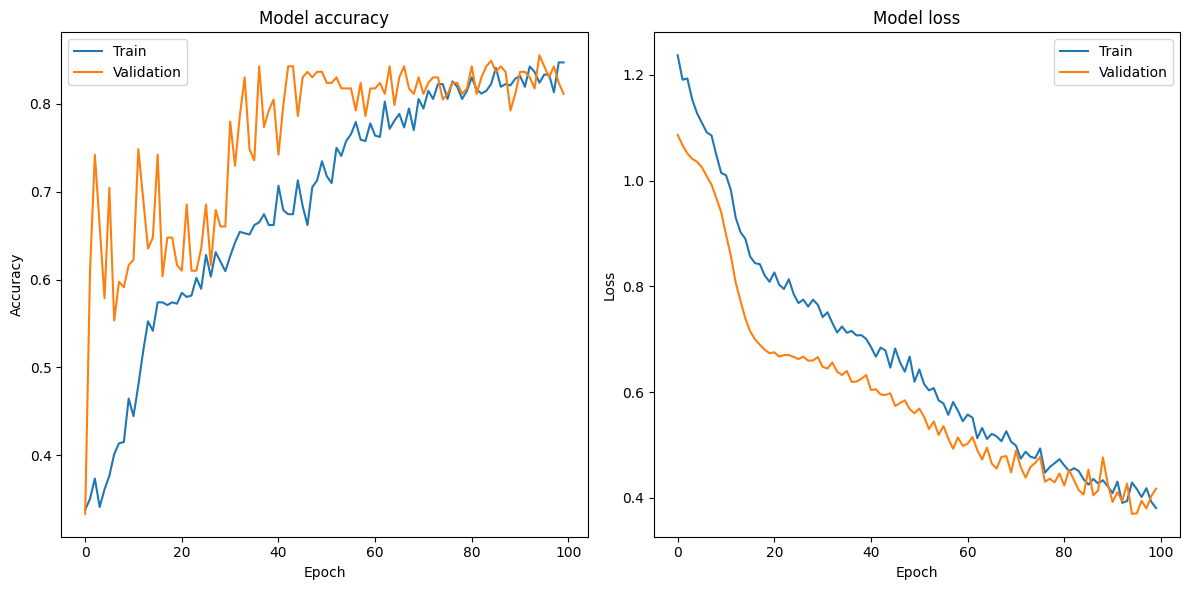

In [ ]:
# Step 8: Plotting accuracy and loss graphs
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()

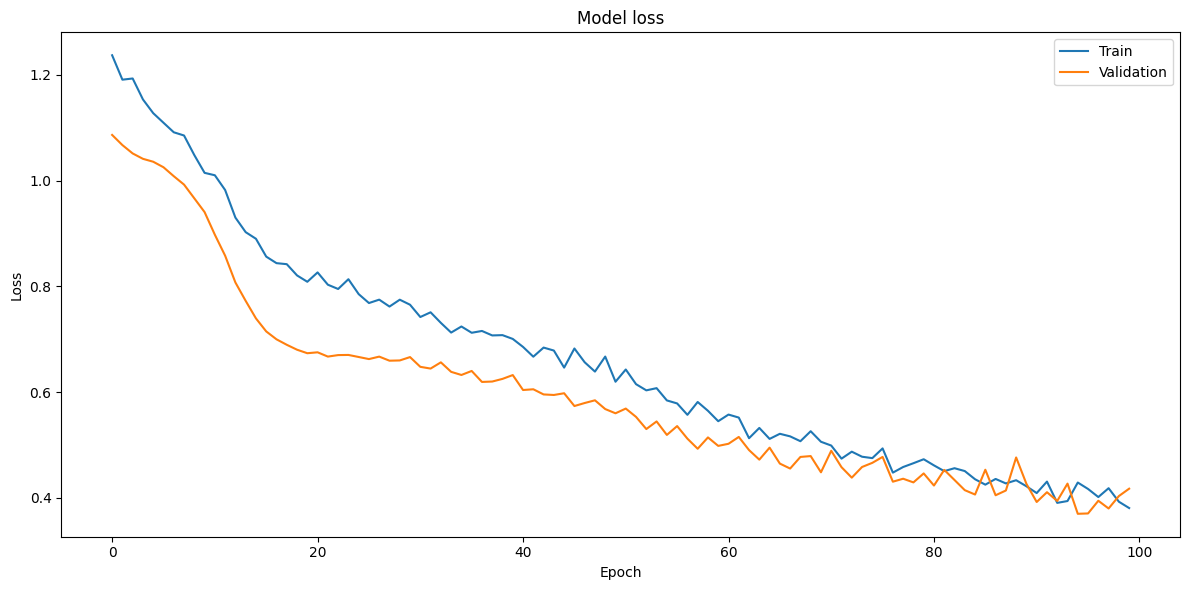

In [ ]:
# Step 9: Plotting loss graph
plt.figure(figsize=(12, 6))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])

plt.tight_layout()
plt.show()